# Прогнозирование оттока клиента оператора связи

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Предстоит разработать прототип модели, которая подскажет с кем из клиентов следует поработать над удержанием, чтобы они не ушли от заказчика. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**

Оператор предоставляет два основных типа услуг:
1.	Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2.	Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:
* contract_new.csv — информация о договоре;
* personal_new.csv — персональные данные клиента;
* internet_new.csv — информация об интернет-услугах;
* phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020.

**Целевой признак**: факт ухода клиента, этот признак можно получить из признака EndDate датасета с договорами.

**Критерии оценки модели**: ROC-AUC должен быть не менее 0.85.

## Обзор данных

Импортируем нужные библиотеки, считаем данные из датасетов и напишем функцию, отвечающую за их первичный анализ.

In [1]:
# перейдем в широкоформатный режим
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# установим необходимые библиотеки
!pip install -q catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.8 MB/s eta 0:00:00


In [3]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from datetime import datetime

from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from numpy.random import RandomState
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [4]:
# начальное состояние генератора случайных чисел
RANDOM_STATE = 250923

In [5]:
# считаем датафреймы
data_contract = pd.read_csv('/datasets/contract_new.csv')
data_personal = pd.read_csv('/datasets/personal_new.csv')
data_internet = pd.read_csv('/datasets/internet_new.csv')
data_phone = pd.read_csv('/datasets/phone_new.csv')

In [6]:
# напишем функцию, выполняющую первичный анализ данных
def overview_data(data):
    # выведем первые 20 строк
    display(data.head(20))
    # выведем информацию о датафрейме
    data.info()

    # выведем описание данных
    display(data.describe())

    # построим общую гистограмму для всех числовых признаков таблицы, если они есть
    if len(data.dtypes[data.dtypes != 'object']) > 0:
        data.hist(figsize=(15, 15), bins=20);
        plt.show()

    # выберем категориальные признаки
    categorical_columns = data.select_dtypes(include=['object'])

    # выведем уникальные значения для категориальных признаков
    for column in categorical_columns:
        print(f'Распределение значений в столбце {column}:')
        print(data[column].value_counts())
        print('\n')

    # посчитаем количество явных дубликатов
    print('Количество явных дубликатов в таблице:', data.duplicated().sum())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


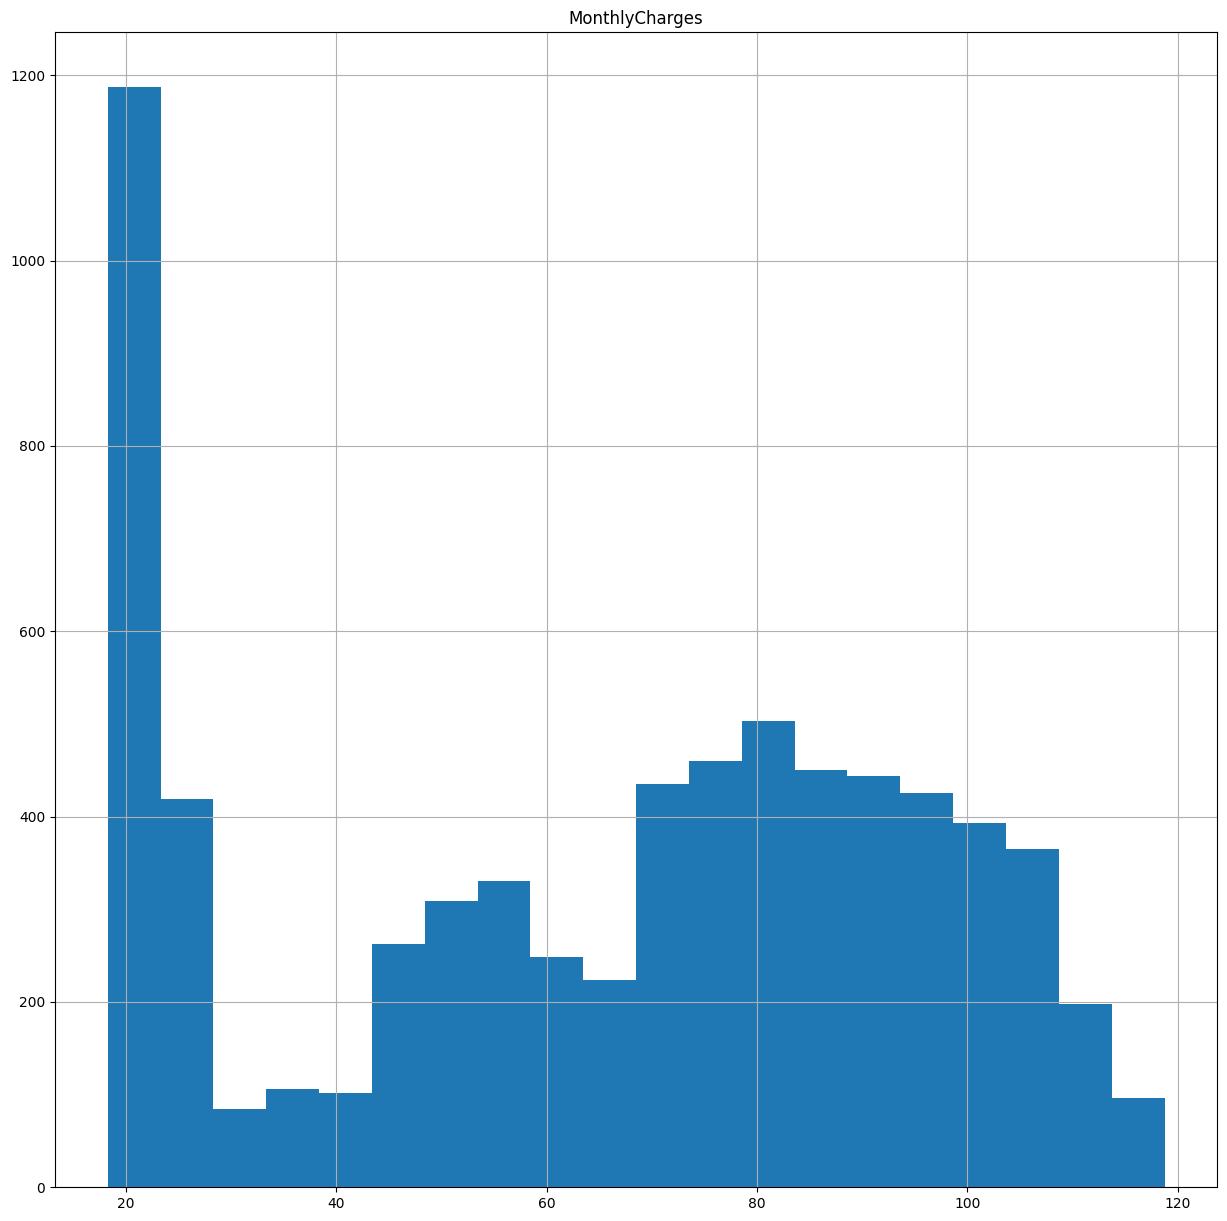

Распределение значений в столбце customerID:
7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: customerID, Length: 7043, dtype: int64


Распределение значений в столбце BeginDate:
2014-02-01    366
2019-10-01    237
2019-11-01    237
2019-09-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: BeginDate, Length: 77, dtype: int64


Распределение значений в столбце EndDate:
No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-09-01       2
2014-12-01       2
2014-06-01       1
2014-10-01       1
2014-11-01       1
Name: EndDate, Length: 67, dtype: int64


Распределение значений в столбце Type:
Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64


Распределение знач

In [7]:
# выполним первичный анализ данных о договорах
overview_data(data_contract)

По данным о договорах заметим следующее:
* в датасете 7043 записи, значения `customerID` уникальны,
* пропусков нет,
* явных дубликатов нет,
* есть только один числовой признак `MonthlyCharges`, но `TotalCharges` по значениям в нем тоже является числовым, нужно будет изменить его тип,
* в числовом признаке `MonthlyCharges` выбросов нет
* типы призаков `BeginDate` и `EndDate` должны бы быть типа дата, но далее лучше создадим на основе этих двух признаков два новых признака - факт ухода клиента от опреатора связи и количество дней, которые он являлся клиентов оператора.

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


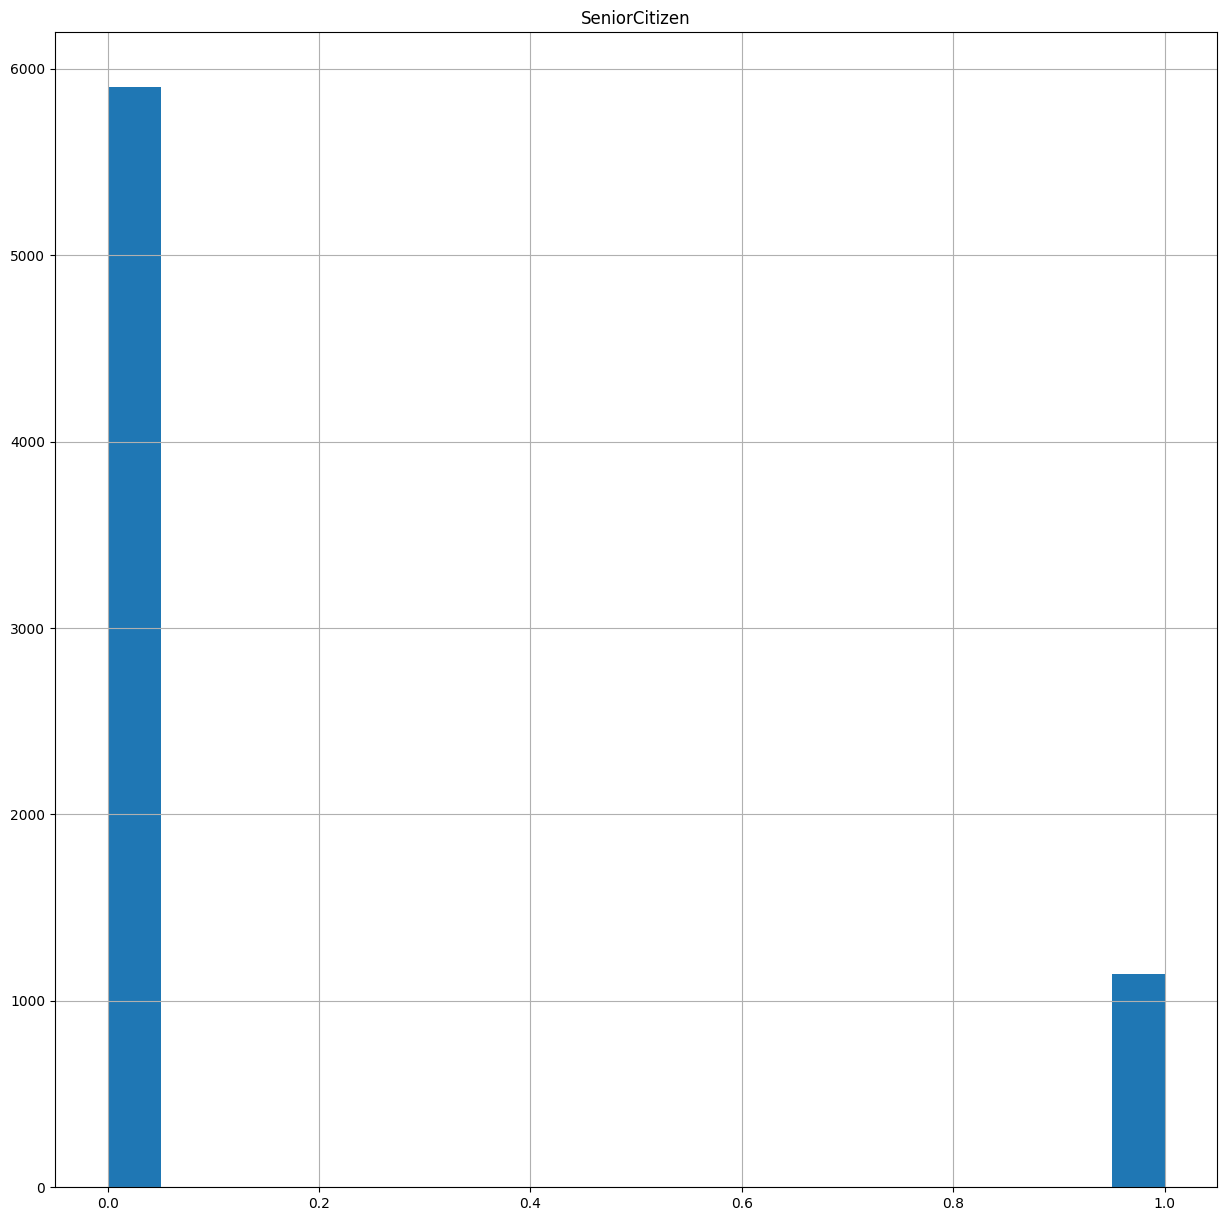

Распределение значений в столбце customerID:
7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: customerID, Length: 7043, dtype: int64


Распределение значений в столбце gender:
Male      3555
Female    3488
Name: gender, dtype: int64


Распределение значений в столбце Partner:
No     3641
Yes    3402
Name: Partner, dtype: int64


Распределение значений в столбце Dependents:
No     4933
Yes    2110
Name: Dependents, dtype: int64


Количество явных дубликатов в таблице: 0


In [8]:
# выполним первичный анализ персональных данных клиентов
overview_data(data_personal)

По персональным данным клиентов заметим следующее:
* в датасете 7043 записи, значения `customerID` уникальны,
* пропусков нет,
* явных дубликатов нет,
* все признаки категориальные, несмотря на то, что тип признака `SeniorCitizen` числовой. По сути он все равно является категориальным, поэтому чтобы модели более корректно его обрабатывали, далее преобразуем его к строковому типу со значениям Yes, No.

In [9]:
# выполним первичный анализ данных об интернет-услугах
overview_data(data_internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Распределение значений в столбце customerID:
7590-VHVEG    1
5181-OABFK    1
9356-AXGMP    1
5176-OLSKT    1
7508-DQAKK    1
             ..
1104-FEJAM    1
2972-YDYUW    1
4238-JSSWH    1
0869-PAPRP    1
3186-AJIEK    1
Name: customerID, Length: 5517, dtype: int64


Распределение значений в столбце InternetService:
Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64


Распределение значений в столбце OnlineSecurity:
No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64


Распределение значений в столбце OnlineBackup:
No     3088
Yes    2429
Name: OnlineBackup, dtype: int64


Распределение значений в столбце DeviceProtection:
No     3095
Yes    2422
Name: DeviceProtection, dtype: int64


Распределение значений в столбце TechSupport:
No     3473
Yes    2044
Name: TechSupport, dtype: int64


Распределение значений в столбце StreamingTV:
No     2810
Yes    2707
Name: StreamingTV, dtype: int64


Распределение значений в столбце StreamingMovies:
No     2785
Yes 

По данным об интернет-услугах заметим следующее:
* в датасете 5517 записи, значения `customerID` уникальны,
* пропусков нет,
* явных дубликатов нет,
* есть только категориальные признаки, причем во всех них всего 2 категории.

In [10]:
# выполним первичный анализ данных об услугах телефонии
overview_data(data_phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


Распределение значений в столбце customerID:
5575-GNVDE    1
0980-FEXWF    1
8082-GHXOP    1
3393-FMZPV    1
8701-DGLVH    1
             ..
8197-BFWVU    1
9154-QDGTH    1
8499-BRXTD    1
8552-OBVRU    1
3186-AJIEK    1
Name: customerID, Length: 6361, dtype: int64


Распределение значений в столбце MultipleLines:
No     3390
Yes    2971
Name: MultipleLines, dtype: int64


Количество явных дубликатов в таблице: 0


По данным об услугах телефонии заметим следующее:
* в датасете 6361 записи, значения `customerID` уникальны,
* пропусков нет,
* явных дубликатов нет,
* есть только один категориальный признак со значениями Yes, No.

<div style="border:solid green 2px; padding: 20px">

Выводы обзора данных:
* в каждом из датасетов значения `customerID` уникальны;
* во всех датасетах пропусков, выбросов, явных дубликатов нет, то есть данные уже пришли обработанные;
* далее для удобства моделирования датасеты нужно будет объединить по `customerID`;
* признак `TotalCharges` по значениям в нем является числовым, нужно будет изменить его тип;
* типы призаков `BeginDate` и `EndDate` должны бы быть типа дата, но далее лучше создадим на основе этих двух признаков два новых признака - факт ухода клиента от опреатора связи и количество дней, которые он являлся клиентов оператора;
* тип признака `SeniorCitizen` числовой, но по сути он все равно является категориальным. Поэтому чтобы модели более корректно его обрабатывали, далее преобразуем его к строковому типу со значениям Yes, No.
* у категориальных признаков небольшое число категорий.
    
</div>

## План дальнейшей работы

1. После выполненного обзора данных, объединим датасеты по `customerID`. Данных немного, поэтому объединять будем без потери данных. Так как количество записей в датасетах разное, появятся пропуски, далее нужно будет их обработать.
2. Выполним предобработку этого датасета: исправим неудачные типы данных, выделим из данных новые более полезные признаки, удалим ненужные признаки, обработаем пропуски после объединения датасетов.
3. Разделим данные на выборки, выполним кодирование и масштабирование данных. С pipeline я еще не работала, но в рамках этой работы попробую разобраться с ними и применить.
4. Далее будем выполнять моделирование и искать наилучшие модели по метрике ROC-AUC. Хочу попровать следующие модели: линейная, случайного леса, LightGBM, CatBoost.
5. Протестируем лучшую найденную модель и проверим ее на адекватность.
6. Проведем исследование важности признаков лучшей модели.

## Предобработка данных

### Объединение датасетов

Для удобства объединим датасеты по `customerID`. Данных немного, поэтому объединять будем их без потери данных. Так как количество записей в датасетах разное, появятся пропуски, далее нужно будет их обработать.

In [11]:
data = data_contract.merge(data_personal, on='customerID', how='outer')
data = data.merge(data_internet, on='customerID', how='outer')
data = data.merge(data_phone, on='customerID', how='outer')

# проверим результат объединения
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


### Заполнение пропусков

Все столбцы с пропусками - категориальные, для незаполненных значений в них введем новую категорию 'undefined' и заполним пропуски этим значением:

In [12]:
for column in data.columns.values.tolist():
    data[column] = data[column].fillna('undefined')

#проверим, что пропуски в датасете заполнены
data.isna().sum().sort_values(ascending=False)

customerID          0
BeginDate           0
StreamingMovies     0
StreamingTV         0
TechSupport         0
DeviceProtection    0
OnlineBackup        0
OnlineSecurity      0
InternetService     0
Dependents          0
Partner             0
SeniorCitizen       0
gender              0
TotalCharges        0
MonthlyCharges      0
PaymentMethod       0
PaperlessBilling    0
Type                0
EndDate             0
MultipleLines       0
dtype: int64

### Переименование столбцов

Столбцы `customerID` и `gender` выбиваются из всех столбцов тем, что наинаются с маленькой буквы, переименуем их:

In [13]:
data = data.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender'})

# проверим результат переименования столбцов
print(data.columns.values.tolist())

['CustomerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']


### Преобразование типов

Признак `TotalCharges` по значениям в нем является числовым, изменим его тип на float:

In [14]:
data['TotalCharges'] = data['TotalCharges'].replace(' ', 0).astype('float')

data[['TotalCharges']].dtypes

TotalCharges    float64
dtype: object

Тип признака `SeniorCitizen` числовой, но по сути он все равно является категориальным. Поэтому чтобы модели более корректно его обрабатывали, далее преобразуем его к строковому типу со значениям Yes, No.

In [15]:
data['SeniorCitizen'] = data['SeniorCitizen'].replace(0, 'No').replace(1, 'Yes').astype('str')

data[['SeniorCitizen']].dtypes

SeniorCitizen    object
dtype: object

### Выделение новых признаков

В датасете есть признаки `BeginDate`, `EndDate` - даты начала и окончания действия договора, но целевым признаком является факт ухода клиента от оператора связи. И также для предсказания интереснее не сама дата начала договора, а продолжительность периода действия договора, рассчитаем ее в днях. В задании было указано, что информация о договорах актуальна на 1 февраля 2020, поэтому если не указана дата окончания договора, будем использовать эту дату для вычисления продолжительности периода действия договора. Добавим эти новые признаки:

In [16]:
# напишем функцию, вычисляющую факт ухода клиента, где 1 означает, что клиент ушел, а 0 - не ушел
def is_customer_left(end_date):
    if end_date == 'No':
        return 0
    else:
        return 1

In [17]:
# добавим признак факта ухода клиента
data['CustomerLeft'] = data['EndDate'].apply(is_customer_left)

# проверим результат создания целевого признака
display(data.head(20))

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,CustomerLeft
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,No,...,No,DSL,No,Yes,No,No,No,No,undefined,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,No,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,No,...,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,No,...,No,DSL,Yes,No,Yes,Yes,No,No,undefined,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,No,...,No,Fiber optic,No,No,No,No,No,No,No,0
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,No,...,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,0
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,No,...,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes,0
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,Female,No,...,No,DSL,Yes,No,No,No,No,No,undefined,0
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,No,...,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,Male,No,...,Yes,DSL,Yes,Yes,No,No,No,No,No,1


In [18]:
# напишем функцию, преобразующую строку к дате
def convert_to_date(date):
    return datetime.strptime(date, '%Y-%m-%d')

# напишем функцию, вычисляющую продолжительность в днях периода действия договора
def contract_duration(begin_date, end_date):
    if end_date == 'No':
        return (convert_to_date('2020-02-01') - convert_to_date(begin_date)).days
    else:
        return (convert_to_date(end_date) - convert_to_date(begin_date)).days

In [19]:
# добавим признак продолжительности периода действия договора
data['ContractDuration'] = data.apply(
    lambda x: contract_duration(x['BeginDate'], x['EndDate']), axis=1)

# проверим результат создания целевого признака
display(data.head(20))

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,CustomerLeft,ContractDuration
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,No,...,DSL,No,Yes,No,No,No,No,undefined,0,31
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,No,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,No,...,DSL,Yes,Yes,No,No,No,No,No,0,123
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,No,...,DSL,Yes,No,Yes,Yes,No,No,undefined,0,1371
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,No,...,Fiber optic,No,No,No,No,No,No,No,0,153
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,No,...,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,0,337
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,No,...,Fiber optic,No,Yes,No,No,Yes,No,Yes,0,671
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,Female,No,...,DSL,Yes,No,No,No,No,No,undefined,0,306
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,No,...,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,0,945
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,Male,No,...,DSL,Yes,Yes,No,No,No,No,No,1,882


### Удаление неинформативных признаков

Новые, более информативные, признаки добавлены, теперь исходные признаки `BeginDate`, `EndDate` можно удалить. Признак `CustomerID` тоже не информативен, удалим его:

In [20]:
data.drop(['BeginDate', 'EndDate', 'CustomerID'], axis=1, inplace=True)

# проверим, что столбцы удалены
data.columns.values.tolist()

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines',
 'CustomerLeft',
 'ContractDuration']

<div style="border:solid green 2px; padding: 20px">

Результаты предобработки:
* все датасеты объединены в один по `customerID` без потери данных;
* все столбцы с пропусками были категориальными, пропуски в них заполнили новой категорией 'undefined';
* столбец `gender` переименовали на `Gender` с большой буквы, как в остальных столбцах;
* признак `TotalCharges` по значениям в нем является числовым, преобразоавали его к float;
* тип признака `SeniorCitizen` числовой, но по сути он все равно является категориальным. Поэтому чтобы модели более корректно его обрабатывали, далее преобразовали его к строковому типу со значениям Yes, No;
* на основе признаков `BeginDate` и `EndDate` создали два новых признака - факт ухода клиента от опреатора связи и количество дней, которые он являлся клиентов оператора;
* удалили неинформативные признаки `BeginDate`, `EndDate`, `customerID`.
    
</div>

##  Разделение данных на выборки

Подготовим тренировочные и тестовые данные для обучения моделей:

In [21]:
# выделим признаки для обучения и целевой признак
features = data.drop('CustomerLeft', axis=1)
target = data['CustomerLeft']

# разделим исходные данные на тренировочную и тестовую выборку в соотношении 3:1 с использованием стратификации по целевому признаку
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE, stratify=target)

## Обучение моделей

Для упрощения напишем функцию, которая с помощью RandomizedSearchCV подбираем лучшую модель по метрике ROC-AUC среди переданных параметров:

In [22]:
def find_best_model(pipeline, parameters):
    grid_search = GridSearchCV(
        pipeline, parameters, scoring='roc_auc', cv=3, n_jobs=-1, error_score = 'raise')
    grid_search.fit(features_train, target_train)

    print('Наилучшая модель', grid_search.best_params_)
    print('ROC-AUC наилучшей модели', abs(grid_search.best_score_))

    return grid_search, abs(grid_search.best_score_)

### Логистическая регрессия

Для логистичекской модели важно предварительно подговить данные: выполнить кодирование категориальных признаков с помощью OneHotEncoder и выполнить масштабирование численных признаков. Для удобства сделаем это в pipeline:

In [23]:
category_columns = ['Type', 'PaperlessBilling', 'PaymentMethod', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity',
                     'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
numeric_columns = ['MonthlyCharges', 'TotalCharges', 'ContractDuration']

# создадим ColumnTransformer для предобработки признаков: кодирования категориальных и масштабирования численных
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(sparse=False, drop='first'), category_columns),
        ('scal', StandardScaler(), numeric_columns)
    ])

# создадим pipeline с предобработкой признаков и логистической регрессией
pipeline_lr = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('log', LogisticRegression(random_state=RANDOM_STATE,
                                   max_iter = 1000))
    ])

params_lr = {
   'log__C': range(2, 15, 1)
}

In [24]:
%%time
lc_best_search, lc_best_score = find_best_model(pipeline_lr, params_lr)

Наилучшая модель {'log__C': 2}
ROC-AUC наилучшей модели 0.7645124393437084
CPU times: user 638 ms, sys: 157 ms, total: 796 ms
Wall time: 10.5 s


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Модель случайного леса

Для модели случайного леса нужно выполнить кодирование категориальных признаков с помощью OrdinalEncoder, выполнять масштабирование численных признаков не требуется.

In [25]:
# создадим ColumnTransformer для предобработки признаков: кодирования категориальных и пропуска численных признаков
ordinal_encoder_preprocessor = ColumnTransformer(
    transformers=[
        ('oe', OrdinalEncoder(), category_columns),
        ('scal', 'passthrough', numeric_columns)
    ],
    # удалить все остальные столбцы
    remainder='drop'
)

# создадим pipeline с предобработкой признаков и моделью случайного леса
pipeline_rfc = Pipeline(
    [
        ('preprocessor', ordinal_encoder_preprocessor),
        ('rfc', RandomForestClassifier(random_state=RANDOM_STATE))
    ])

params_rfc = {
   'rfc__n_estimators': [100, 200, 300],
   'rfc__max_depth': [None, 8, 12, 16],
}


In [26]:
%%time
rfс_best_search, rfс_best_score = find_best_model(pipeline_rfc, params_rfc)

Наилучшая модель {'rfc__max_depth': 8, 'rfc__n_estimators': 300}
ROC-AUC наилучшей модели 0.8321723349962994
CPU times: user 2.31 s, sys: 124 ms, total: 2.44 s
Wall time: 46.9 s


### Модель LightGBM

Для моделей LightGBM и CatBoost не нужно предварительно выполнять кодирование категориальных признаков и масштабирование численных признаков, они сами с этим справляются. Но для корректной работы этих моделей нужно предварительно поменять тип категориальных переменных на category:

In [27]:
# предварительно скопируем датасет, чтобы избежать ошибок
features_train = features_train.copy()
features_train.loc[:, category_columns] = features_train[category_columns].astype('category')

features_test = features_test.copy()
features_test.loc[:, category_columns] = features_test[category_columns].astype('category')

<ipython-input-27-9a4723132fa9>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  features_train.loc[:, category_columns] = features_train[category_columns].astype('category')
<ipython-input-27-9a4723132fa9>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  features_test.loc[:, category_columns] = features_test[category_columns].astype('category')


In [28]:
# создадим pipeline с моделью LightGBM
pipeline_lgbm = Pipeline(
    [
        #('preprocessor', ordinal_encoder_preprocessor),
        ('lgbm', LGBMClassifier(random_state=RANDOM_STATE, verbose=1000))
    ])

params_lgbm = {
   'lgbm__max_depth': [5, 10],
   'lgbm__num_leaves': [400, 500],
   'lgbm__learning_rate' : [0.3]
}


In [29]:
%%time
lgbmc_best_search, lgbmc_best_score = find_best_model(pipeline_lgbm, params_lgbm)

[LightGBM] [Info] Number of positive: 826, number of negative: 4456
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.769784
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.400417
[LightGBM] [Debug] init for col-wise cost 0.000855 seconds, init for row-wise cost 0.002777 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 752
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156380 -> initscore=-1.685412
[LightGBM] [Info] Start training from score -1.685412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[

### Модель CatBoost

Для модели CatBoost не нужно предварительно выполнять кодирование категориальных признаков и масштабирование численных признаков, она сама с этим справляется.

In [30]:
# создадим pipeline с моделью CatBoost
pipeline_cbc = Pipeline(
    [
        ('cbc', CatBoostClassifier(random_state=RANDOM_STATE, verbose=1000, cat_features=category_columns))
    ])

params_cbc = {
   'cbc__max_depth': [None, 5, 10],
   'cbc__learning_rate' : [0.1, 0.5]
}

In [31]:
%%time
cbc_best_search, cbc_best_score = find_best_model(pipeline_cbc, params_cbc)

0:	learn: 0.6227663	total: 63.3ms	remaining: 1m 3s
999:	learn: 0.0966577	total: 14.9s	remaining: 0us
Наилучшая модель {'cbc__learning_rate': 0.1, 'cbc__max_depth': 5}
ROC-AUC наилучшей модели 0.8942656561001541
CPU times: user 29.3 s, sys: 2.05 s, total: 31.4 s
Wall time: 9min


<div style="border:solid green 2px; padding: 20px">

Наилучшей оказалась модель Catboost, на тренировочной выборке у нее ROC-AUC = 0.89, далее идет модель LightGBM с ROC-AUC = 0.86, далее модель случайного леса с ROC-AUC = 0.83, и далее логистическая модель с ROC-AUC = 0.76
    
</div>

## Тестирование и проверка на адекватность лучшей модели

### Тестирование лучшей модели

Проверим, как лучшая модель отрабатывает на тестовой выборке:

In [32]:
# определим функцию, вычиляющую ROC-AUC модели на тестовой выборке
def test_model(best_estimator):
    # вычислим вероятности класса 1
    prediction_probabilities_test = best_estimator.predict_proba(features_test)[:, 1]
    roc_auc_test = roc_auc_score(target_test, prediction_probabilities_test)
    print('Итоговый ROC-AUC на тестовой выборке', roc_auc_test)

In [33]:
# протестируем модель CatBoost
test_model(cbc_best_search.best_estimator_)

Итоговый ROC-AUC на тестовой выборке 0.9037440352379786


На тестовой выборке ROC-AUC лучшей модели 0.90. Таким образом требуемая в задаче граница метрики в 0.85 преодолена.

### Проверка на адекватность лучшей модели

Сравним, как соотносятся полученные результаты с результатами фиктивного классификатора, который будет прогнозировать классы в соответствии с их относительными частотами в исходных данных:

In [34]:
dc_model = DummyClassifier(strategy='stratified')
dc_parameters = {}

dc_best_search, dc_best_score = find_best_model(dc_model, dc_parameters)
test_model(dc_best_search.best_estimator_)

Наилучшая модель {}
ROC-AUC наилучшей модели 0.5045284586228078
Итоговый ROC-AUC на тестовой выборке 0.4882662425058118


Результаты ROC-AUC на тестовой выборке наилучшей модели 0.90, что значительно превосходит результаты фиктивного классификатора 0.51, поэтому модель адекватна.

<div style="border:solid green 2px; padding: 20px">

* На тестовой выборке ROC-AUC лучшей модели 0.90. Таким образом требуемая в задаче граница метрики в 0.85 преодолена.
* Результаты ROC-AUC на тестовой выборке наилучшей модели 0.90, что значительно превосходит результаты фиктивного классификатора 0.49, поэтому модель адекватна.
    
</div>

## Построение матрицы ошибок и исследование важности признаков

### Построение матрицы ошибок

Посмотрим, насколько хорошо наилучшая модель предсказывает положительные и отрицательные значения.

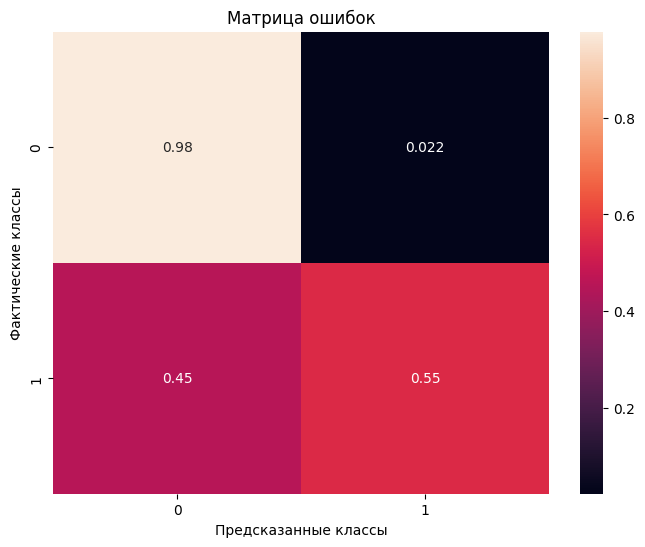

In [35]:
cbc_predictions_test = cbc_best_search.predict(features_test)
confusion = confusion_matrix(target_test, cbc_predictions_test, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True)
plt.xlabel("Предсказанные классы")
plt.ylabel("Фактические классы")
plt.title("Матрица ошибок")
plt.show()

Наилучшая модель Catboost отлично предсказывает отрицательные значения c с долей правильных ответов 0.98, когда клиент не ушел от оператора связи. Но положительные значения, когда клиент ушел, модель предсказывает не очень хорошо - с долей 0.55.

### Исследование важности признаков

Определим, какие из признаков вносят наибольший вклад в результат предсказания наилучшей модели CatBoost:

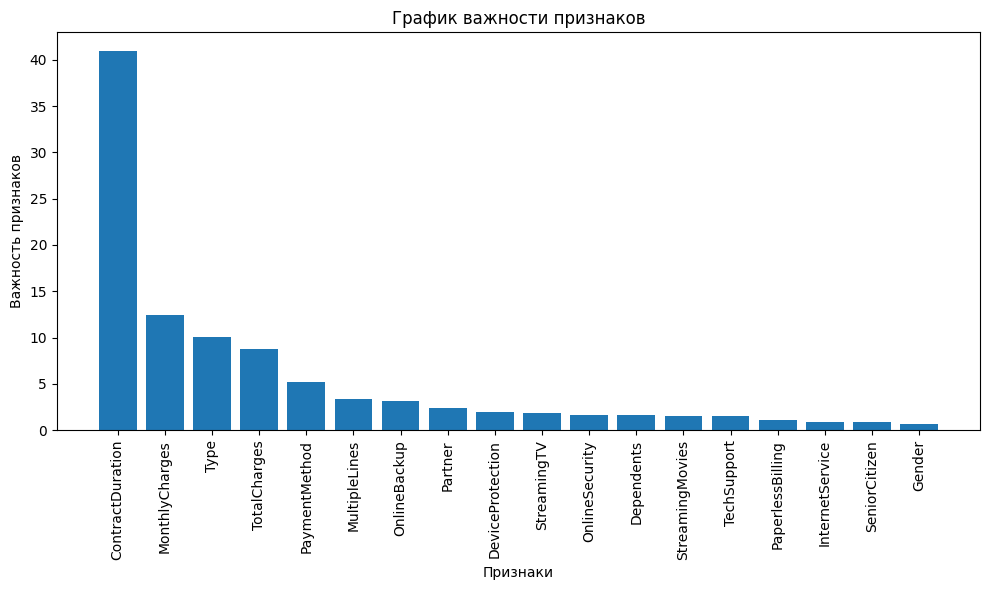

In [36]:
feature_importance = cbc_best_search.best_estimator_['cbc'].feature_importances_
feature_names = features_train.columns

# создадим список индексов, отсортированный по значению feature_importance
sorted_indices = sorted(range(len(feature_importance)), key=lambda i: feature_importance[i], reverse=True)

#отсортируем feature_importance и feature_names
sorted_feature_importance = [feature_importance[i] for i in sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# отобразим график важности признаков
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_feature_importance)), sorted_feature_importance, tick_label=sorted_feature_names)
plt.xlabel('Признаки')
plt.ylabel('Важность признаков')
plt.title('График важности признаков')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Наибольший вклад в предсказания наилучшей модели вносят признаки `ContractDuration`, `MonthlyCharges`, `TotalCharges`, `Type`, `PaymentMethod`.

<div style="border:solid green 2px; padding: 20px">

* Наилучшая модель Catboost отлично предсказывает отрицательные значения c с долей правильных ответов 0.98, когда клиент не ушел от оператора связи. Но положительные значения, когда клиент ушел, модель предсказывает не очень хорошо - с долей 0.55.
* Наибольший вклад в предсказания наилучшей модели вносят признаки `ContractDuration`, `MonthlyCharges`, `TotalCharges`, `Type`, `PaymentMethod`.
    
</div>

## Ход решения проекта

### Соответствие исходному плану

Вспомним исходный план и посмотри, какие пункты были выполнены, а какие нет:
1. После выполненного обзора данных, объединим датасеты по `customerID`. Данных немного, поэтому объединять будем без потери данных. Так как количество записей в датасетах разное, появятся пропуски, далее нужно будет их обработать.
2. Выполним предобработку этого датасета: исправим неудачные типы данных, выделим из данных новые более полезные признаки, удалим ненужные признаки, обработаем пропуски после объединения датасетов.
3. Разделим данные на выборки, выполним кодирование и масштабирование данных. С pipeline я еще не работала, но в рамках этой работы попробую разобраться с ними и применить.
4. Далее будем выполнять моделирование и искать наилучшие модели по метрике ROC-AUC. Хочу попровать следующие модели: линейная, случайного леса, LightGBM, CatBoost.
5. Протестируем лучшую найденную модель и проверим ее на адекватность.
6. Проведем исследование важности признаков лучшей модели.

В итоге все пункты были выполнены.

В качестве линейной модели мы использовали логистическую регрессию, так как она хорошо подходит для задач классификации.

Оказалось, что некоторые модели градиентного бустинга, такие как LightGBM или Catboost, не требуют предварительного кодирования категориальных признаков. Для них нужно было преобразовать категориальные столбцы к типу category, и дальше эти модели сами используют встроенные алгоритмы кодирования.

### Возникшие трудности

Вспомним, с какими трудностями мы столкнулись во время выполнения проекта:
* не получалось достичь требуемой метрики ROC-AUC на тестовой выборке. Оказалось, что для вычиления ROC-AUC можно использовать предсказанные вероятности с помощью model.predict_proba, после этого метрика стала заметно лучше и стала удовлетворять требованиям.
* не получалось модель LightGBM обучать на датасете без предварительного приведения типов категориальных признаков к category. Привели и получилось.
* для построения графика важности признаков не получалось получить список признаков после применения кодирования в pipeline. В итоге оказалось, что наилучшую модель можно предварительно не кодировать, поэтому не пришлось решать эту проблему.
* изначально целевым признаком сделала столбец со строковыми данными Yes, No, в итоге возникали ошибки при обучении моделей. В итоге изменила тип этого признака на числовой со значениями 0, 1. Проблема ушла.
* после добавления pipeline не получалось поочередно применять кодирование и масштабирование к части признаков. В итоге разобралась, что для этого можно использовать ColumnTransformer.

### Ключевые шаги проекта

Выделим следующие ключевые шаги проекта:
1. Обзор данных, составление списка их особеностей, которые нужно было устранить перед обучением моделей на них.
2. Составление плана дальнейшей работы и валидация его у тимлида.
3. Предобработка данных
4. Разделение данных на выборки
5. Обучение моделей
6. Выбор наилучшей модели по метрике, тестирование этой модели, проверка ее на адеватность
7. Построение матрицы ошибок и исследование важности признаков наилучшей модели
8. Написание выводов по проекту.

## Общие выводы

<div style="border:solid green 2px; padding: 20px">

В проекте требовалось разработать прототип **модели, которая подскажет, с кем из абонентов оператора связи следует поработать над удержанием**, чтобы они не ушли от заказчика. Целевой признак - это факт ухода клиента, этот признак можно получить из признака EndDate датасета с договорами. **ROC-AUC модели по требованию задачи должен быть не менее 0.85.**

Данные состоят из файлов, полученных из разных источников:
* contract_new.csv — информация о договоре;
* personal_new.csv — персональные данные клиента;
* internet_new.csv — информация об интернет-услугах;
* phone_new.csv — информация об услугах телефонии.

----------------------------------------------------------------------------

Выводы обзора данных:
* в каждом из датасетов значения кодов клиента `customerID` уникальны;
* во всех датасетах пропусков, выбросов, явных дубликатов нет, то есть данные уже пришли обработанные;
* далее для удобства моделирования датасеты нужно будет объединить по `customerID`;
* признак `TotalCharges` по значениям в нем является числовым, нужно будет изменить его тип;
* типы призаков `BeginDate` и `EndDate` должны бы быть типа дата, но далее лучше создадим на основе этих двух признаков два новых признака - факт ухода клиента от опреатора связи и количество дней, которые он являлся клиентов оператора;
* тип признака `SeniorCitizen` числовой, но по сути он все равно является категориальным. Поэтому чтобы модели более корректно его обрабатывали, далее преобразуем его к строковому типу со значениям Yes, No.
* у категориальных признаков небольшое число категорий.

----------------------------------------------------------------------------

Результаты предобработки данных:
* все датасеты объединены в один по `customerID` без потери данных;
* все столбцы с пропусками были категориальными, пропуски в них заполнили новой категорией 'undefined';
* столбец `gender` переименовали на `Gender` с большой буквы, как в остальных столбцах;
* признак `TotalCharges` по значениям в нем является числовым, преобразоавали его к float;
* тип признака `SeniorCitizen` числовой, но по сути он все равно является категориальным. Поэтому чтобы модели более корректно его обрабатывали, далее преобразовали его к строковому типу со значениям Yes, No;
* на основе признаков `BeginDate` и `EndDate` создали два новых признака - факт ухода клиента от опреатора связи и количество дней, которые он являлся клиентов оператора;
* удалили неинформативные признаки `BeginDate`, `EndDate`, `customerID`.

----------------------------------------------------------------------------

* Попробовали обучить следующие модели для решения этой задачи: логистичекая, случайного леса, LightGBM, CatBoost.
* **Наилучшей оказалась модель Catboost, на тренировочной выборке у нее ROC-AUC = 0.89, далее идет модель LightGBM с ROC-AUC = 0.86, далее модель случайного леса с ROC-AUC = 0.83, и далее логистическая модель с ROC-AUC = 0.76.**
* **Для решения задачи выбрали модель Catboost со следующими гиперпараметрами:
learning_rate = 0.1, max_dept = 5.**

----------------------------------------------------------------------------

* При оценке **качества модели на тестовой выборке ROC-AUC лучшей модели 0.90.** Таким образом требуемая в задаче граница метрики в 0.85 преодолена.
* Результаты ROC-AUC на тестовой выборке наилучшей модели 0.90, что значительно превосходит результаты фиктивного классификатора 0.49, поэтому модель адекватна.

----------------------------------------------------------------------------

* Наилучшая модель Catboost отлично предсказывает отрицательные значения c с долей правильных ответов 0.98, когда клиент не ушел от оператора связи. Но положительные значения, когда клиент ушел, модель предсказывает не очень хорошо - с долей 0.55.

---------------------------------------------------------------------------

Список признаков, используемых для обучения лучшей модели:

 * `Type` - тип оплаты: раз в год-два или ежемесячно,
 * `PaperlessBilling` - электронный расчётный лист,
 * `PaymentMethod` - тип платежа,
 * `MonthlyCharges` - расходы за месяц,
 * `TotalCharges` - общие расходы абонента,
 * `Gender` - пол абонента,
 * `SeniorCitizen` - является ли абонент пенсионером,
 * `Partner` - есть ли у абонента супруг или супруга,
 * `Dependents` - есть ли у абонента дети,
 * `InternetService` - тип подключения интернета,
 * `OnlineSecurity` - блокировка опасных сайтов,
 * `OnlineBackup` - облачное хранилище файлов для резервного копирования данных,
 * `DeviceProtection` - антивирус,
 * `TechSupport` - выделенная линия технической поддержки,
 * `StreamingTV` - стриминговое телевидение,
 * `StreamingMovies` - каталог фильмов,
 * `MultipleLines` - подключение телефона к нескольким линиям одновременно,
 * `CustomerLeft` - факт ухода абонента от оператора связи,
 * `ContractDuration` - количество дней, которые он являлся абонентом оператора.

**Наибольший вклад в предсказания наилучшей модели вносят признаки `ContractDuration`, `MonthlyCharges`, `TotalCharges`, `Type`, `PaymentMethod`.**

    
</div>